<a href="https://colab.research.google.com/github/sagar9926/RecurrentNeuralNetworks/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Introduce dataset 
2. Data processing - Test-train split, encoding, visualisation
3. Basic RNN - testing inference
4. Evaluation and training
5. LSTM
6. GRU
7. Exercises

In [0]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output

## Dataset

In [84]:
!wget https://raw.githubusercontent.com/biku1998/Name2lang-RNN-LSTM-GRU-Pytorch/master/Data/name2lang.txt

--2020-05-09 19:21:42--  https://raw.githubusercontent.com/biku1998/Name2lang-RNN-LSTM-GRU-Pytorch/master/Data/name2lang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 339465 (332K) [text/plain]
Saving to: ‘name2lang.txt.2’

name2lang.txt.2     100%[===================>] 331.51K  --.-KB/s    in 0.06s   

2020-05-09 19:21:42 (5.15 MB/s) - ‘name2lang.txt.2’ saved [339465/339465]



In [0]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)# used to dimension the output layer in sequence model

In [86]:

print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [87]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


### Train-test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [89]:
print(X_train)

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko', 'Sokolsky', 'Masuno', 'Varela', 'Moffat', 'Bonner', 'Berezovsky', 'Helkvist', 'Thurston', 'Tovstuha', 'Millar', 'Tulintsev', 'Furey', 'Isaenko', 'Kalachev', 'Takecare', 'Newcombe', 'Taku', 'Artibyakin', 'Saifulov', 'Morcos', 'Jagodnikov', 'Halifman', 'Bagaryakoff', 'Pavluhin', 'Mari', 'Awramchik', 'Agaltsov', 'Fisichev', 'Shizuma', 'Yankin', 'Luts', 'Toshitala', 'Germain', 'Botros', 'Poulter', 'Lischenko', 'Porter', 'Melendez', 'Ibu', 'Carr', 'Ursler', 'Aderikhin', 'Gimondi', 'Rzhevsky', 'Slater', 'Atkin', 'Yagafarov', 'Huraskin', 'Underhill', 'Pylin', 'Yuschenko', 'Ardovini', 'Tunison', 'Dobrovolsky', 'Bezyzvestnyh', 'Roussel', 'Balakshin', 'Trumbauer', 'Vallance', 'Boerio', 'Waugh', 'Baz', 'Reading', 'Komon', 'Ireson', 'Venables', 'Tikhotsky', 'Spada', 'Winfield', 'Mikhnov', 'Lubsky', 'Antar', 'Sheehan', 'Tuma', 'Yuzefovich', 'Yamburg', 'Yukhvidov', 'Mikhail', 'Chi', 'De

In [90]:
print(len(X_train), len(X_test))

16040 4010


### Encoding names and language

In [91]:
all_letters = string.ascii_letters + " .,;'" # list of all characters
n_letters = len(all_letters) # this is to dimension input models to accept the size upto 10 letters
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [92]:
rep = torch.zeros(2, 1, n_letters)
print(rep)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [0]:
name = "ab"

In [94]:
for index, letter in enumerate(name):
    print(index,name)
    pos = all_letters.find(letter)
    rep[index][0][pos] = 1
print(rep)

0 ab
1 ab
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])


In [0]:
# function to perform encoding

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) # creating zero vector of size [name,1,all_alphabets]
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [0]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [97]:
name_rep('Abreu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [98]:
name_rep('Abreu').shape

#[5 characters in Abreu ,1 Vector representing the alphabes ,57 Total number of characters in all charactesr(only one bit is high in these 57)]

torch.Size([5, 1, 57])

In [99]:
lang_rep('Portuguese')

tensor([0])

### Basic visualisation

In [100]:
print(data)

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese'), ('Campos', 'Portuguese'), ('Cardozo', 'Portuguese'), ('Castro', 'Portuguese'), ('Coelho', 'Portuguese'), ('Costa', 'Portuguese'), ('Crespo', 'Portuguese'), ('Cruz', 'Portuguese'), ("D'cruz", 'Portuguese'), ("D'cruze", 'Portuguese'), ('Delgado', 'Portuguese'), ('De santigo', 'Portuguese'), ('Duarte', 'Portuguese'), ('Esteves', 'Portuguese'), ('Fernandes', 'Portuguese'), ('Ferreira', 'Portuguese'), ('Ferreiro', 'Portuguese'), ('Ferro', 'Portuguese'), ('Fonseca', 'Portuguese'), ('Franco', 'Portuguese'), ('Freitas', 'Portuguese'), ('Garcia', 'Portuguese'), ('Gaspar', 'Portuguese'), ('Gomes', 'Portuguese'), ('Gouveia', 'Portuguese'), ('Guerra', 'Portuguese'), ('Henriques', 'Portuguese'), ('Lobo', 'Portuguese'), ('Machado', 'Portug

In [101]:
for d in data:
  print(d[1])

Streaming output truncated to the last 5000 lines.
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russi

In [102]:
count = {}
for l in languages: 
    count[l] = 0

print(count)

for d in data:

    count[d[1]] += 1

print(count)

{'Portuguese': 0, 'Irish': 0, 'Spanish': 0, 'Vietnamese': 0, 'Chinese': 0, 'Greek': 0, 'Czech': 0, 'Dutch': 0, 'Japanese': 0, 'French': 0, 'German': 0, 'Scottish': 0, 'English': 0, 'Russian': 0, 'Polish': 0, 'Arabic': 0, 'Korean': 0, 'Italian': 0}
{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


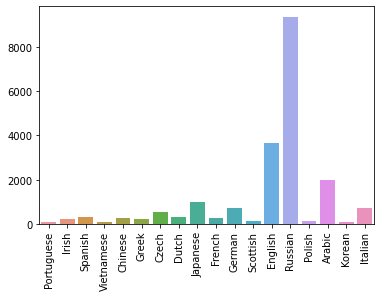

In [103]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Basic network and testing inference


![](https://cdn-images-1.medium.com/fit/t/1600/480/0*uwlfcVIiHHr-zF_0.png)

![](https://miro.medium.com/max/846/1*k_DGDc274hMk4CE8KOW4OQ.png)

In [0]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): 
      # input size : size of the representation of given character i.e number of letters :57(orange vector)
      # hidden size : can be seen in the diagram, the blue vector, we have a single layer but its size can be changed : Hyper parameter
      # Output size : number of languages we have [one hot encoded vector]
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        # below is given previous hidden value and the current input compute the hidden output
        # Given U and W compute next state, so somehow we are concatenating the input and prev hidden state vector to a larger vector
        # outputting the hidden vector for next state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        #Computing green vector given blue and orange
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):      
        combined = torch.cat((input_, hidden), 1) # concatenating along particular axis
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [0]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name) # one hot encoding of the name
    print(name_ohe)
    hidden = net.init_hidden() # nititalise the hidden vector, very first h0 cant be calculated, all zeroes initially
    print(hidden)
    
    for i in range(name_ohe.size()[0]): # iterate over each character, [Number of characters in name , 1, total number of characters in vocab]

        output, hidden = net(name_ohe[i], hidden) #passing 1 character one hot vector and hidden state to model at a time
        # making one invocation of forward for a single character of size [1,N], we always give input to RNN of form [1, something]
        # we are over riding the output and hidden after every forward pass of one character 
    
    return output

In [107]:
output = infer(net, 'Adam')
index = torch.argmax(output)
print(output, index)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## Evaluate model

In [0]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [109]:
dataloader(2, X_train, y_train)

[('Chu',
  'Korean',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]]]),
  tensor([16])),
 ('Tikhobrazov',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          

In [0]:
def eval(net, n_points, k, X_, y_): # k : to calculate top k accuracy
    
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_: # to iterate over list of tuples
        
        output = infer(net, name)
        val, indices = output.topk(k) # Top K
        
        if lang_rep in indices: # if ground truth in top k then correct
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [111]:
eval(net, 1000, 3, X_test, y_test)

Streaming output truncated to the last 5000 lines.
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

0.062

## Training

### Basic setup

In [0]:
# Here we are going through same network again and again, and we perform back propogation through time
#


def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()   # consider this as one batch, we are updating weights after one batch     
            
    return total_loss/n_points

In [0]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [114]:
%%time 
train(net, opt, criterion, 200)

CPU times: user 267 ms, sys: 2.82 ms, total: 270 ms
Wall time: 280 ms


tensor(2.9015, grad_fn=<DivBackward0>)

In [115]:
eval(net, 1000, 1, X_test, y_test)

Streaming output truncated to the last 5000 lines.
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

0.498

### Full training setup

If model already has softamax at the end then use : Nehetive log liklihood

else Cross entropy which would internally compute the Forward pass and Backwarcd pass through softmax



In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5):
    
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
                      

Streaming output truncated to the last 5000 lines.
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
        [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0.,

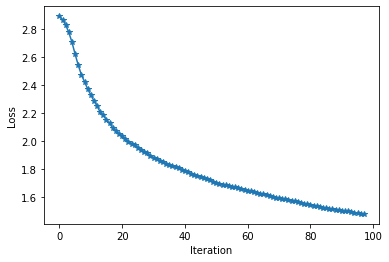

In [117]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

## LSTM cell

![](https://miro.medium.com/max/2000/1*aKc2BBkeFXYZ4kZk44oBiA.png)

![](https://miro.medium.com/max/1400/1*aR_1Bj7dFhSAt_WMyg2vcA.png)

In [0]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden) # reshaping the input
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)) # one for hidden and other for cell state
        # lstm can have multiple layers ( layers, batches)

Streaming output truncated to the last 5000 lines.
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])
(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

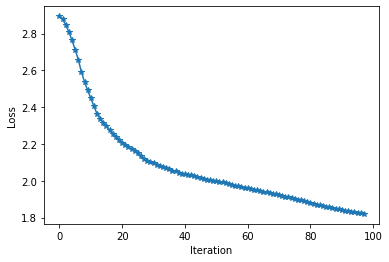

In [120]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

## GRU Cell

In [0]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input_, hidden):
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

Streaming output truncated to the last 5000 lines.
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0.,

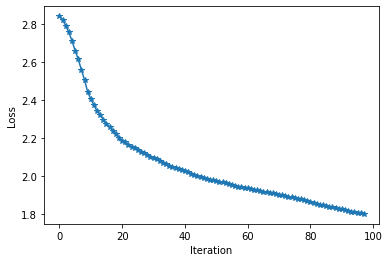

In [122]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

## Exercises

0. Compute language-wise accuracy, plot confusion matrix 
1. Play with hyper-parameters (includes hidden layer size) and try to get better results
2. Observe gradient explosion at higher learning rates
3. Increase performance by moving to GPUs (shown earlier)
4. Think about how to increase performance further (idea: are we benefiting from batching in our implementation?)

